In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import os
import ast
from dataloader import PKDataloader
import torch
from imagand import SDT, EMA
from diffusion import DDIMScheduler
from sklearn.metrics import mean_squared_error
from utils import sample_noise
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import csv
from tabulate import tabulate


# Set True if new samples generation is needed
generate_new_samples = False

# Change the trained model name

model_path = "t5_embed_model/"
#model_path = "deberta_embed_model/"
#model_path = "MHGGNN_embed_model/"
#model_path = "chemberta_zinc_embed_model/"
#model_path = "chemberta_10m_embed_model/"

model_name = model_path.split("_")[0] if len(model_path.split("_"))==3 else model_path.split("_")[0]+"_"+model_path.split("_")[1]

## Read output file from trained model

In [2]:
def get_training_results(model_path):
    output_file = "output.txt"
    val_epochs = []
    val_loss = []
    train_epochs = []
    train_loss = []
    with open(model_path+output_file) as f:
        for x in f:
            x = x.replace("np.float32(","").replace(")","")
            dict_line = ast.literal_eval(x)
            epoch = int(dict_line['e'])
            t_loss = float(dict_line['avgloss'])
            train_epochs.append(epoch)
            train_loss.append(t_loss)
            v_loss = dict_line.get('avgvalmse')
            if v_loss:
                val_epochs.append(epoch)
                val_loss.append(v_loss)
             
    val_epochs = np.array(val_epochs, dtype=np.int32)
    val_loss = np.array(val_loss, dtype=np.float32)  
    train_epochs = np.array(train_epochs, dtype=np.int32)  
    train_loss = np.array(train_loss,dtype=np.float32)
    return train_epochs,train_loss,val_epochs,val_loss

## Plot Training/Val error

In [3]:
def plot_train_val_error(train_epochs,train_loss,val_epochs,val_loss,mod_name):
    min_loss=val_loss.min()
    min_epoch=val_epochs[np.argmin(val_loss)]
    print(f"Min loss (val): {min_loss}, at epoch: {min_epoch}\n")
    plt.plot(train_epochs,train_loss, color='r', label='Train')
    plt.plot(val_epochs,val_loss, color='g', label='Val')
    plt.axvline(min_epoch, linestyle='--', color='blue', alpha=0.25, label='min loss')
    plt.xlabel("Epochs")
    plt.ylabel("Avg loss (MSE)")
    plt.title(f"Training/Validation error ({mod_name})")
    plt.legend()
    plt.show()

Min loss (val): 0.21500365436077118, at epoch: 990



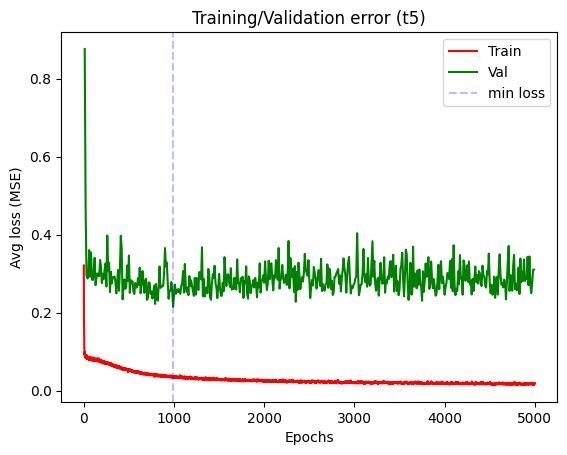

Min loss (val): 0.20853467285633087, at epoch: 1170



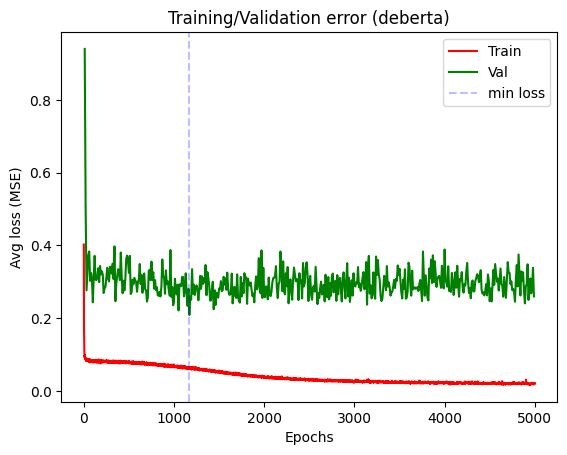

Min loss (val): 0.19199974834918976, at epoch: 1160



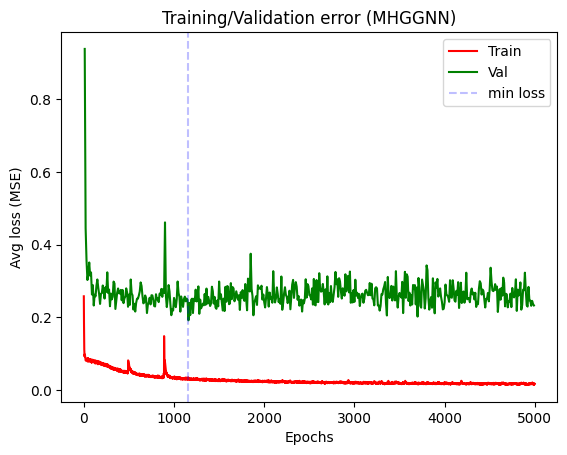

Min loss (val): 0.20855355262756348, at epoch: 4320



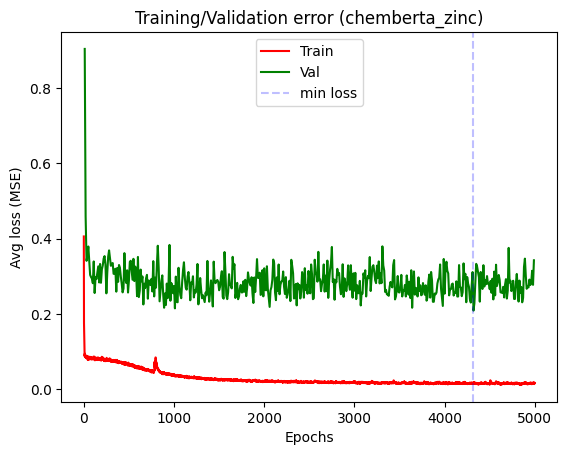

Min loss (val): 0.2188860923051834, at epoch: 1540



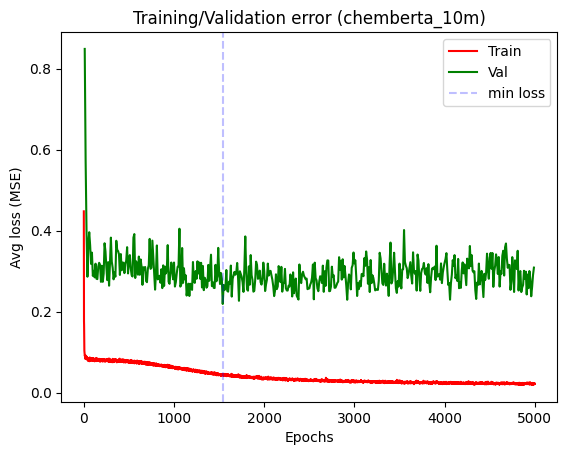

In [4]:
full_model_list = ["t5","deberta","MHGGNN","chemberta_zinc","chemberta_10m"]
for mod_name in full_model_list:
    model_path_tmp = mod_name+"_embed_model/"
    train_epochs,train_loss,val_epochs,val_loss = get_training_results(model_path_tmp)
    plot_train_val_error(train_epochs,train_loss,val_epochs,val_loss,mod_name)

Model: t5
Min loss (val): 0.21500365436077118, at epoch: 990

Model: deberta
Min loss (val): 0.20853467285633087, at epoch: 1170

Model: MHGGNN
Min loss (val): 0.19199974834918976, at epoch: 1160



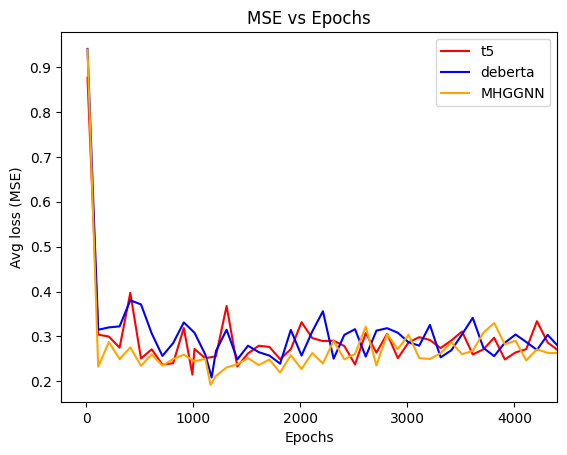

In [5]:
def plot_mse_models(model_list,color_list):
    for i,model_n in enumerate(model_list):
        mod_path = model_n+"_embed_model/"
        train_epochs,train_loss,val_epochs,val_loss = get_training_results(mod_path)
        min_loss=val_loss.min()
        min_epoch=val_epochs[np.argmin(val_loss)]
        val_epochs_inter = list(val_epochs[::10])
        val_loss_inter = list(val_loss[::10])
        val_epochs_inter.append(min_epoch)
        val_epochs_inter = sorted(val_epochs_inter)
        indx_min = val_epochs_inter.index(min_epoch)
        val_loss_inter = val_loss_inter[:indx_min] +[min_loss]+val_loss_inter[indx_min:]
        print(f"Model: {model_n}")
        print(f"Min loss (val): {min_loss}, at epoch: {min_epoch}\n")
        plt.plot(val_epochs_inter,val_loss_inter, color=color_list[i], label=model_n)
        #plt.axvline(min_epoch, linestyle='--', color='blue', alpha=0.25, label='min loss')

    plt.xlim(xmax=4400)
    plt.xlabel("Epochs")
    plt.ylabel("Avg loss (MSE)")
    plt.title("MSE vs Epochs")
    plt.legend()
    plt.show()

model_list = ["t5","deberta","MHGGNN"] #,"chemberta_zinc","chemberta_10m"]
color_list = ["red","blue","orange"] #,"green","pink"]
plot_mse_models(model_list,color_list)

Model: chemberta_zinc
Min loss (val): 0.20855355262756348, at epoch: 4320

Model: chemberta_10m
Min loss (val): 0.2188860923051834, at epoch: 1540



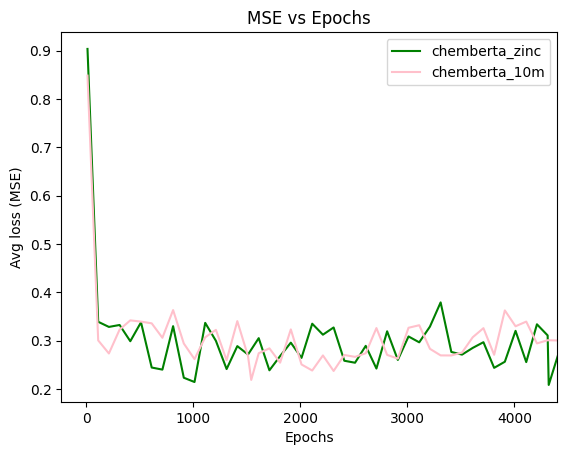

In [6]:
model_list = ["chemberta_zinc","chemberta_10m"]
color_list = ["green","pink"]
plot_mse_models(model_list,color_list)

## Create DataFrames for analysis (Synthetic/Real data)

In [7]:
adme_names = [
            'Caco2_Wang',
            'PPBR_AZ',
            'VDss_Lombardo',
            'Half_Life_Obach',
            'LD50_Zhu'
        ]
def get_best_data_dfs(model_path):
    train_epochs,train_loss,val_epochs,val_loss = get_training_results(model_path)
    min_loss=val_loss.min()
    min_epoch=val_epochs[np.argmin(val_loss)]
    
    csv_data_file = f'{min_epoch}_dict.csv'
    df_data_orig = pd.read_csv(model_path+csv_data_file, header=None)
    df_data = df_data_orig.copy()
    for i in range(len(adme_names)):
        df_data[adme_names[i]] = df_data_orig[1].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ')[i])
    df_data["class"] = df_data_orig[0].apply(lambda x: "synthetic")
    df_data.drop([0, 1], axis='columns', inplace=True)
    return df_data_orig, df_data
df_data_orig, df_data = get_best_data_dfs(model_path)

In [8]:
df_data_orig.head(5)

,0,1
0,CCC1(CC)C(=O)C=CN(CN2CCOCC2)C1=O,[ 0.27990177 0.7360378 -1. -0.925205...
1,CCN1CCCC1=O,[-0.01653329 0.94001144 -1. -0.835410...
2,CNC(=O)ON=C1CSCCS1,[ 0.36000517 0.29663798 -0.5935555 -0.247300...
3,CC(=O)NNc1ccc(N)cc1,[-0.2474817 0.84049183 -0.70285594 -0.667446...
4,COc1cc(Nc2nc(N[C@@H](C)c3ncc(F)cn3)ncc2Br)n[nH]1,[ 0.03285167 0.8959401 -0.11553535 -0.450706...


In [9]:
df_data.head(5)

,Caco2_Wang,PPBR_AZ,VDss_Lombardo,Half_Life_Obach,LD50_Zhu,class
0,0.279902,0.736038,-1.000000,-0.925205,0.945822,synthetic
1,-0.016533,0.940011,-1.000000,-0.835411,-0.102911,synthetic
2,0.360005,0.296638,-0.593556,-0.247301,-0.380231,synthetic
3,-0.247482,0.840492,-0.702856,-0.667447,0.267195,synthetic
4,0.032852,0.895940,-0.115535,-0.450707,-0.270432,synthetic


In [10]:
def get_gt_dataframes(model_path):
    csv_data_gt_file = 'gt_dict.csv'
    df_data_gt_orig = pd.read_csv(model_path+csv_data_gt_file)
    df_data_gt_orig
    df_data_gt = df_data_gt_orig[['sm', 'ma', 'gt']]
    for i in range(len(adme_names)):
        null_mask = df_data_gt['ma'].apply(lambda x: np.fromstring(x.strip('[]').replace("False", "0").replace("True", "1"), sep=' ', dtype=bool)[i])
        df_data_gt[adme_names[i]] = df_data_gt['gt'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ')[i]).combine(null_mask, lambda a, b: a if b else np.nan)
    df_data_gt["class"] = df_data_gt['sm'].apply(lambda x: "real")
    df_data_gt.drop(['sm', 'ma', 'gt'], axis='columns', inplace=True)
    return df_data_gt_orig, df_data_gt
df_data_gt_orig, df_data_gt = get_gt_dataframes(model_path)

In [11]:
df_data_gt_orig.head(5)

,sm,ft,ma,gt
0,COC(=O)[C@H]1[C@H]2C[C@@H]3c4[nH]c5cc(OC)ccc5c...,[ 2.87812036e-02 1.89851642e-01 -7.27880746e-...,[ True False False False False],[ 0.05145565 0.53849218 -0.41013134 -0.170850...
1,CC(C)=CC1C(C(=O)Cl)C1(C)C,[ 3.37857395e-01 -3.31595093e-01 -3.85384887e-...,[False False False False True],[ 0.43203408 0.89960665 -0.82989482 -0.825747...
2,O=C(O)c1cc(I)cc(I)c1I,[ 5.20777628e-02 2.41644487e-01 6.61532655e-...,[False False False False True],[ 0.08879891 0.98183853 -0.42523555 -0.851314...
3,Oc1ccccc1,[ 6.58042356e-02 2.65157580e-01 -2.47519817e-...,[False False False False True],[-0.08056614 0.99428048 -0.29718736 -0.168993...
4,O=C1C(CC[S+]([O-])c2ccccc2)C(=O)N(c2ccccc2)N1c...,[-8.93389899e-03 6.80467337e-02 -3.80537473e-...,[False True False True False],[ 0.3996202 0.96218612 -0.93314086 -0.487361...


In [12]:
df_data_gt.head(5)

,Caco2_Wang,PPBR_AZ,VDss_Lombardo,Half_Life_Obach,LD50_Zhu,class
0,0.051456,NaN,NaN,NaN,NaN,real
1,NaN,NaN,NaN,NaN,0.054545,real
2,NaN,NaN,NaN,NaN,0.107761,real
3,NaN,NaN,NaN,NaN,-0.032373,real
4,NaN,0.962186,NaN,-0.487362,NaN,real


In [13]:
df_full_data = pd.concat([df_data,df_data_gt], axis=0)
df_full_data

,Caco2_Wang,PPBR_AZ,VDss_Lombardo,Half_Life_Obach,LD50_Zhu,class
0,0.279902,0.736038,-1.000000,-0.925205,0.945822,synthetic
1,-0.016533,0.940011,-1.000000,-0.835411,-0.102911,synthetic
2,0.360005,0.296638,-0.593556,-0.247301,-0.380231,synthetic
3,-0.247482,0.840492,-0.702856,-0.667447,0.267195,synthetic
4,0.032852,0.895940,-0.115535,-0.450707,-0.270432,synthetic
...,...,...,...,...,...,...
1043,NaN,NaN,NaN,NaN,-0.102439,real
1044,NaN,0.901920,NaN,NaN,NaN,real
1045,NaN,NaN,NaN,NaN,-0.070510,real
1046,NaN,NaN,-0.951442,NaN,NaN,real


## Create Dataloader

In [14]:
class PKDataset(Dataset):
    def __init__(self, df):
        self.sm = df["sm"].tolist()  
        self.ma = df["ma"].tolist()        
        self.ft = df["ft"].tolist()            
        self.gt = df["gt"].tolist()          

    def __len__(self):
        return len(self.sm)

    def __getitem__(self, idx):
        sm = self.sm[idx]             
        ma = torch.tensor(self.ma[idx], dtype=torch.bool)
        ft = torch.tensor(self.ft[idx], dtype=torch.float32)
        gt = torch.tensor(self.gt[idx], dtype=torch.float32)

        return {
            "sm": sm,
            "ma": ma,  
            "ft": ft,  
            "gt": gt,   
        }

# Get dmss only
dataloader = PKDataloader(
    model_name,
    "./data"
)
trainset = dataloader.dataset
dmss = trainset.dmss

10487
10487


In [15]:
df_data_gt_val = df_data_gt_orig.copy()
df_data_gt_val['ft'] = df_data_gt_orig['ft'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
df_data_gt_val['ma'] = df_data_gt_orig['ma'].apply(lambda x: np.fromstring(x.strip('[]').replace("False", "0").replace("True", "1"), sep=' ', dtype=bool))
df_data_gt_val['gt'] = df_data_gt_orig['gt'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
print(df_data_gt_val['ft'][0].shape)
# Build dataset & dataloader
dataset = PKDataset(df_data_gt_val)
val_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

(768,)


## Load trained model

In [16]:
device = "cuda" if torch.cuda.is_available() else "mps" # Change mps for cpu if not a Mac

model = SDT(
    time_dim = 64,
    cond_size = 1024 if model_path.split("_")[0] == 'MHGGNN' else 768,
    patch_size = 16,
    y_dim = 5,
    dim = 256,
    depth = 12,
    heads = 16,
    mlp_dim = 768,
    dropout = 0.1,
    emb_dropout = 0.1
)
model.to(device)

gamma=0.994

ema = EMA(model, gamma, 1000)

best_model = torch.load(model_path+'best_model.pt',map_location=torch.device('mps'))
ns = DDIMScheduler(num_train_timesteps=2000,
                                beta_start=0.,
                                beta_end=0.7,
                                beta_schedule="cosine")

ema_model_state_dict = best_model["ema_model"]
ema.ema_model.load_state_dict(ema_model_state_dict)

<All keys matched successfully>

## Generate Samples

In [17]:
def generate_sample(samp,ema, dataloader, noise_scheduler, n_inference_timesteps=150):
    ema.ema_model.eval()
    before_mse = 0
    running_mse = 0
    global_step = 0
    vals = {}
    ema.ema_model.to(device)
    noise_scheduler.set_timesteps(n_inference_timesteps)
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            sm = batch['sm']
            mask = batch['ma']
            ft = batch['ft'].to(device).float()
            gt = batch['gt'].to(device).float()
            bs = ft.shape[0]

            ys = sample_noise(bs, dmss)
            ys = torch.tensor(ys).float().to(device)
            timestep = torch.tensor([n_inference_timesteps], device=device).long()
            # ys[mask] = noise_scheduler.add_noise(gt[mask], ys[mask], timestep)

            raw_mse = mean_squared_error(gt[mask].flatten().cpu(), ys[mask].flatten().cpu())
            # non_zero_elements = mask.sum()
            # raw_mse = raw_mse / non_zero_elements

            generated_ys = noise_scheduler.generate(
                ema.ema_model,
                ft,
                ys,
                num_inference_steps=n_inference_timesteps,
                eta=0.01,
                use_clipped_model_output=True,
                device = device
            )

            mse = mean_squared_error(gt[mask].flatten().cpu(), generated_ys[mask].flatten().cpu())
            # mse = mse / non_zero_elements

            for s, g in zip(sm, list(generated_ys.cpu().numpy())):
                vals[s] = g
            
            before_mse += raw_mse
            running_mse += mse
            global_step += 1

    with open(model_path+'sample_{}_dict.csv'.format(samp+1), 'w') as csv_file:  
        writer = csv.writer(csv_file)
        for key, value in vals.items():
            writer.writerow([key, value])

    return running_mse / global_step, before_mse / global_step

In [18]:
num_samples = 30
if generate_new_samples:
    for i in range(num_samples):
        print(f"Sample {i+1}/{num_samples}:")
        generate_sample(i,ema, val_dataloader, ns)

## Computing Hellinger distances

In [19]:
def hellinger_from_hist(x, y, bins=30, data_range=None):

    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    
    # Drop NaNs
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    
    if data_range is None:
        data_range = (min(x.min(), y.min()), max(x.max(), y.max()))
    
    # Estimate densities
    hist1, bin_edges = np.histogram(x, bins=bins, range=data_range, density=True)
    hist2, _        = np.histogram(y, bins=bins, range=data_range, density=True)

    # Convert density to probability mass by multiplying by bin width
    widths = np.diff(bin_edges)
    p = hist1 * widths
    q = hist2 * widths

    # Normalize
    p = p / p.sum()
    q = q / q.sum()

    return round(float(np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))),3)

In [20]:
def get_all_hd_values():
    model_paths = ["t5_embed_model/","deberta_embed_model/","chemberta_zinc_embed_model/"] #,"chemberta_10m_embed_model/"]
    all_hd_means = []
    for model_path in model_paths:
        model_name = model_path.split("_")[0] if len(model_path.split("_"))==3 else model_path.split("_")[0]+"_"+model_path.split("_")[1]
        hd_across_samples = np.zeros((num_samples,len(adme_names)+1))
        for k in range(num_samples):
            csv_data_file = f'sample_{k+1}_dict.csv'
            df_data = pd.read_csv(model_path+csv_data_file, header=None)
            for i in range(len(adme_names)):
                df_data[adme_names[i]] = df_data[1].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ')[i])
            df_data["class"] = df_data[0].apply(lambda x: "synthetic")
            df_data.drop([0, 1], axis='columns', inplace=True)
            df_full_data = pd.concat([df_data,df_data_gt], axis=0)
            for j,m_name in enumerate(adme_names):
                x = df_full_data[m_name][df_full_data["class"]=="synthetic"].values
                y = df_full_data[m_name][df_full_data["class"]=="real"].values
                hd = hellinger_from_hist(x, y)
                hd_across_samples[k,j] = hd
            hd_across_samples[k,-1] = round(hd_across_samples[k,:-1].mean(),3)
        mod_hd_means = []
        for i in range(len(adme_names)+1):
            mod_hd_means.append(round(float(hd_across_samples[:,i].mean()),3))
        mod_hd_means = [model_name]+mod_hd_means
        all_hd_means.append(mod_hd_means)
    print(tabulate(all_hd_means, headers=["Model"]+adme_names+["Avg"]))
get_all_hd_values()

Model             Caco2_Wang    PPBR_AZ    VDss_Lombardo    Half_Life_Obach    LD50_Zhu    Avg
--------------  ------------  ---------  ---------------  -----------------  ----------  -----
t5                     0.306      0.34             0.39               0.369       0.149  0.311
deberta                0.28       0.277            0.351              0.313       0.115  0.267
chemberta_zinc         0.277      0.306            0.338              0.346       0.107  0.274


## Univariate plots

In [21]:
print(f"Plots for {model_name.upper()} model")

Plots for T5 model


In [22]:
df_data_gt.describe()

,Caco2_Wang,PPBR_AZ,VDss_Lombardo,Half_Life_Obach,LD50_Zhu
count,75.000000,158.000000,89.000000,56.000000,715.000000
mean,0.209931,0.532633,-0.593903,-0.505372,-0.024527
std,0.318199,0.541247,0.491080,0.493057,0.367089
min,-0.759042,-1.000000,-0.987860,-0.992897,-0.855432
25%,0.041392,0.271492,-0.927162,-0.871736,-0.302217
50%,0.280942,0.768095,-0.827011,-0.717151,-0.069180
75%,0.438458,0.925258,-0.426404,-0.211615,0.190244
max,0.841909,0.999409,0.939302,1.000000,0.999557


In [23]:
df_data.describe()

,Caco2_Wang,PPBR_AZ,VDss_Lombardo,Half_Life_Obach,LD50_Zhu
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,0.135303,0.659181,-0.654544,-0.631420,-0.058471
std,0.253711,0.331916,0.272564,0.252450,0.301127
min,-0.758151,-0.787076,-1.000000,-1.000000,-0.755595
25%,-0.017290,0.590548,-0.840668,-0.786578,-0.276496
50%,0.162520,0.759080,-0.715058,-0.672926,-0.106483
75%,0.312630,0.861897,-0.544758,-0.525085,0.097381
max,0.863112,1.000000,0.611689,0.817902,1.000000


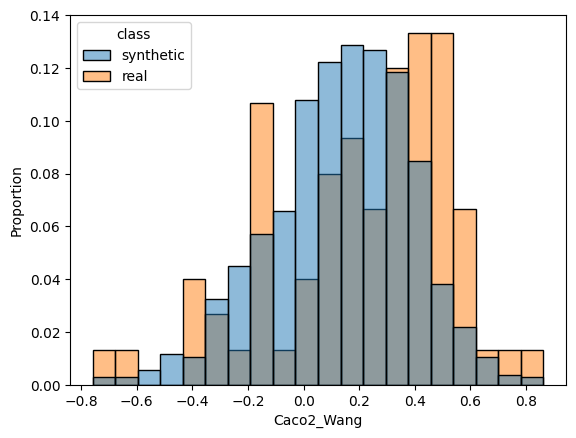

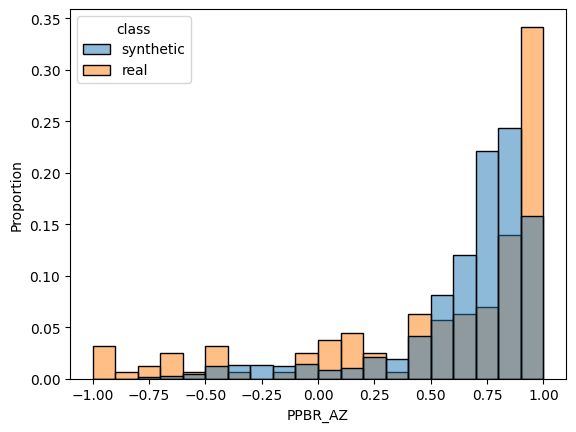

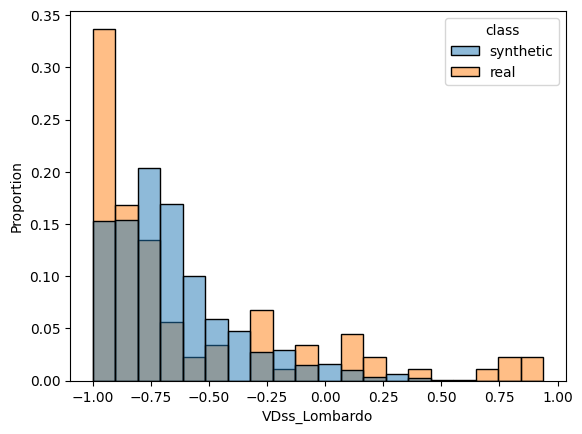

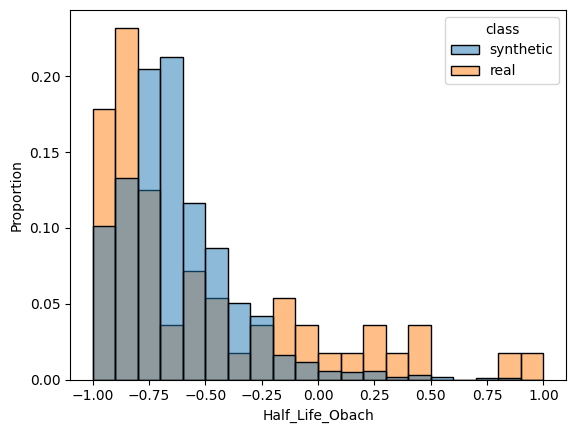

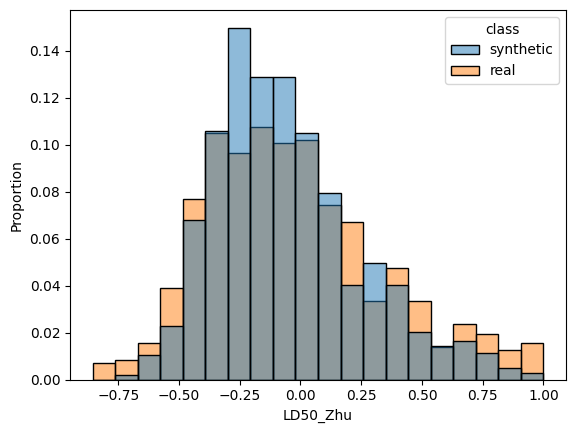

In [24]:
#g = sns.FacetGrid(df_full_data, col="class")
#g.map(sns.histplot, "Caco2_Wang")
df_full_data = df_full_data.reset_index(drop=True)
for ft_name in adme_names:
    sns.histplot(x=ft_name, bins=20, data=df_full_data, hue='class', stat='proportion', common_norm=False)
    plt.show()

## Bivariate plots

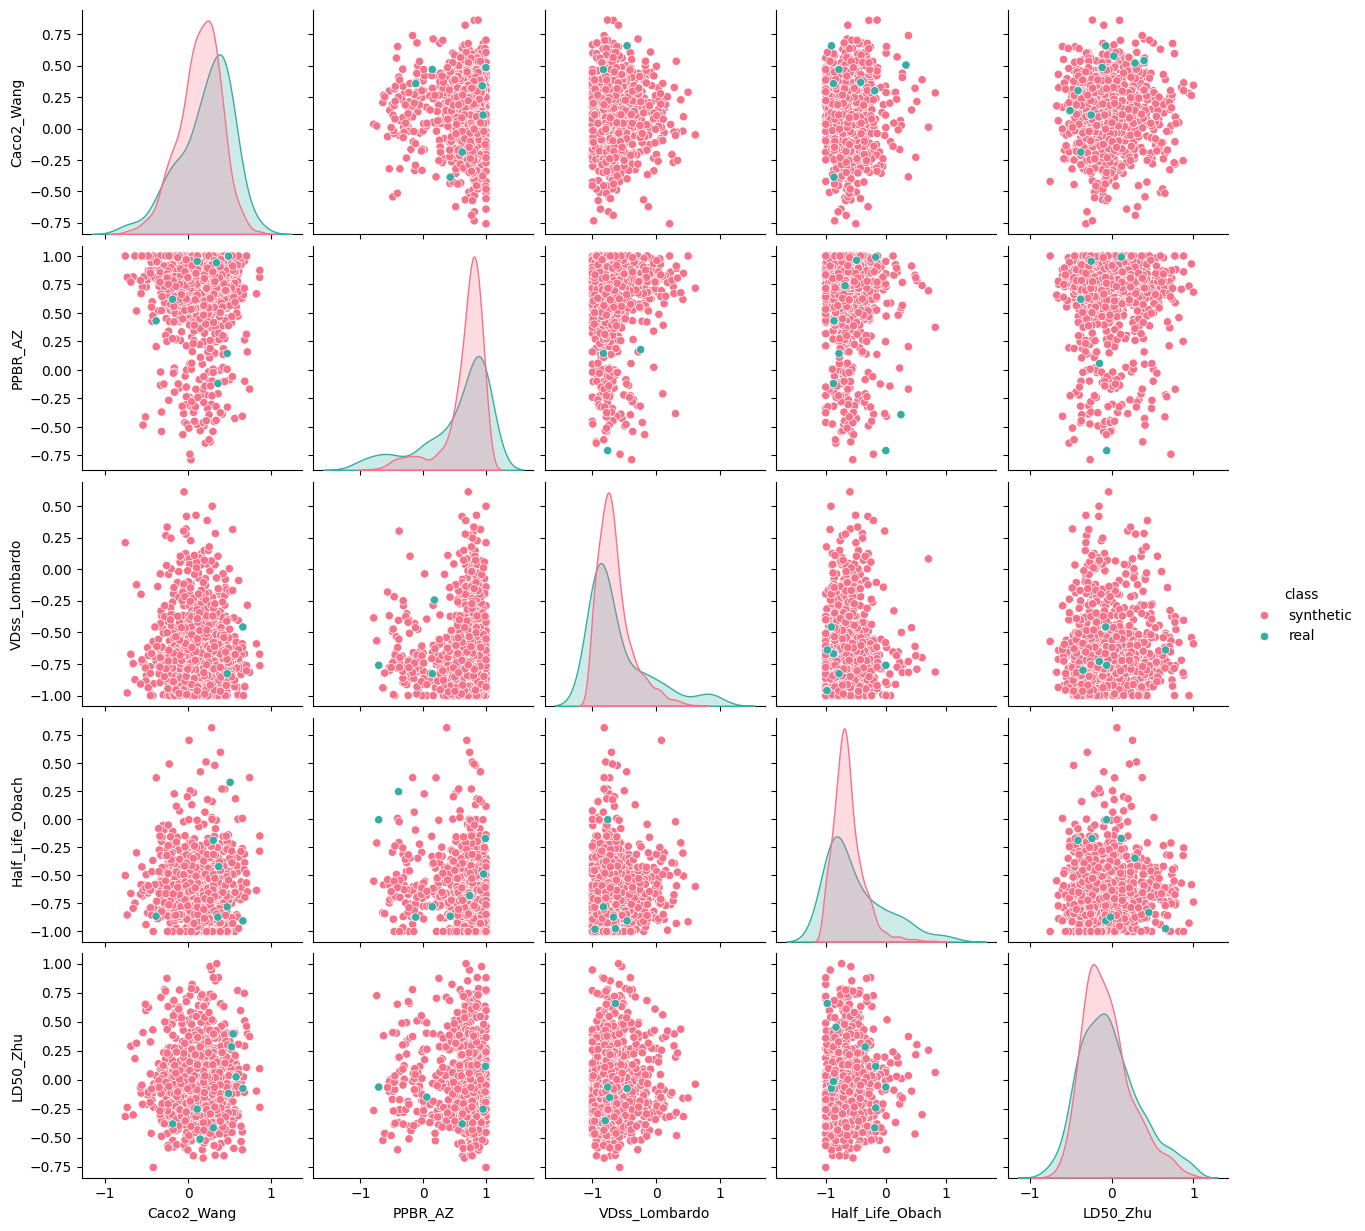

In [25]:
sns.pairplot(data=df_full_data, hue="class", diag_kind="kde", palette="husl", diag_kws=dict(common_norm=False))
plt.show()

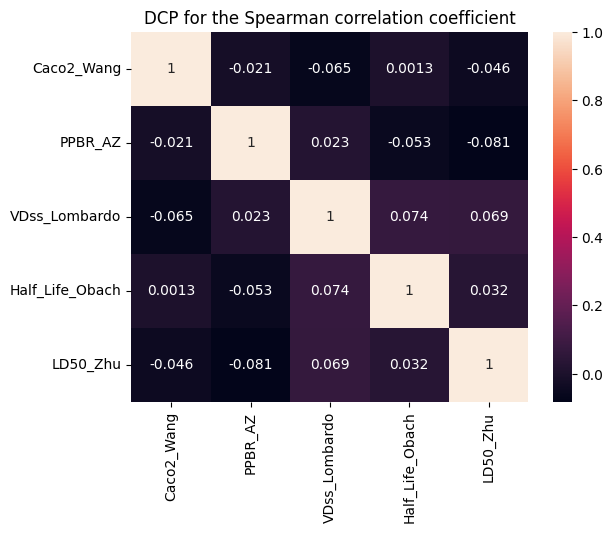

In [26]:
corr = df_full_data[adme_names].corr(method = 'spearman')
sns.heatmap(corr, annot = True)
plt.title("DCP for the Spearman correlation coefficient")
plt.show()

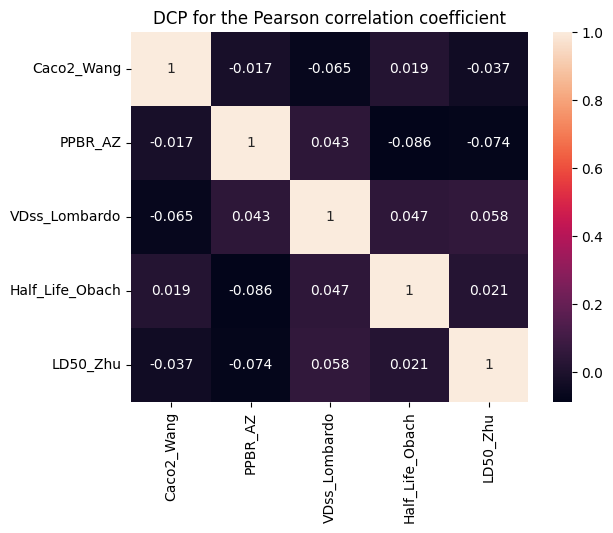

In [27]:
corr = df_full_data[adme_names].corr(method = 'pearson')
sns.heatmap(corr, annot = True)
plt.title("DCP for the Pearson correlation coefficient")
plt.show()